# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by November 8, 2018 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [2]:
import pylab
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()


We will have two toy datasets to try the different methods:

In [3]:
seed = 20
np.random.seed(seed)

In [4]:
# Dataset 1: n = 500, p = 2, K = 3
n1, p1, K1 = (500, 2, 3)
# z1 = np.random.rand(3)
# z1 = z1 / np.sum(z1)  # z[k] = probability to pick mode k
z1 = np.array([1 / K1 for _ in range(K1)])
mu1 = (np.random.rand(K1, p1, ) - 0.5) * 4
cov1 = np.zeros((K1, p1, p1))
for k in range(K1):
    foo1 = (np.random.rand(p1, p1) - 0.5) 
    cov1[k, :, :] = foo1.T.dot(foo1)
    
def pick_mode(z):
    cum = 0
    r = np.random.rand()
    for k in range(z.shape[0] - 1):
        if r <= cum + z[k]:
            return k
        cum += z[k]
    return z.shape[0] - 1

x1 = np.zeros((n1, p1))
for i in range(n1):
    k = pick_mode(z1)
    x1[i, :] = np.random.multivariate_normal(mu1[k, :], cov1[k, :, :])

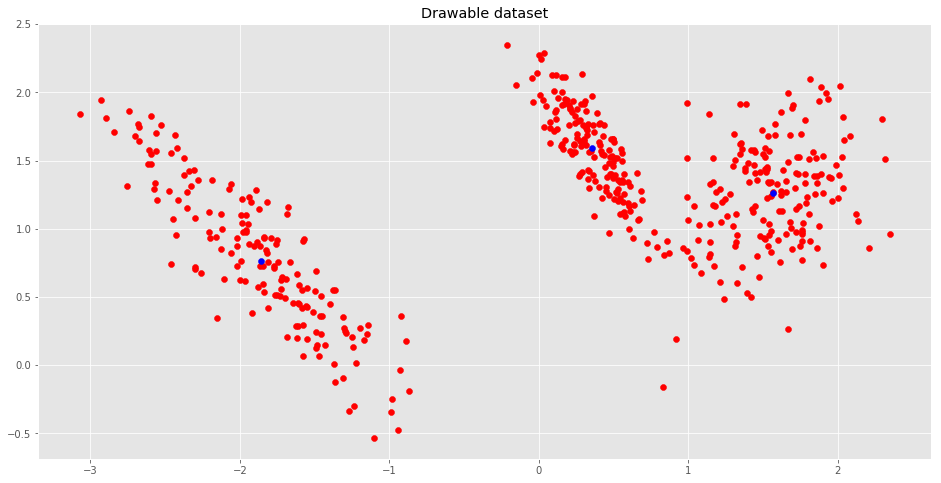

In [5]:
plt.scatter(x1[:, 0], x1[:, 1], color="red")
plt.scatter(mu1[:, 0], mu1[:, 1], color="blue")
plt.title("Drawable dataset")
plt.show()

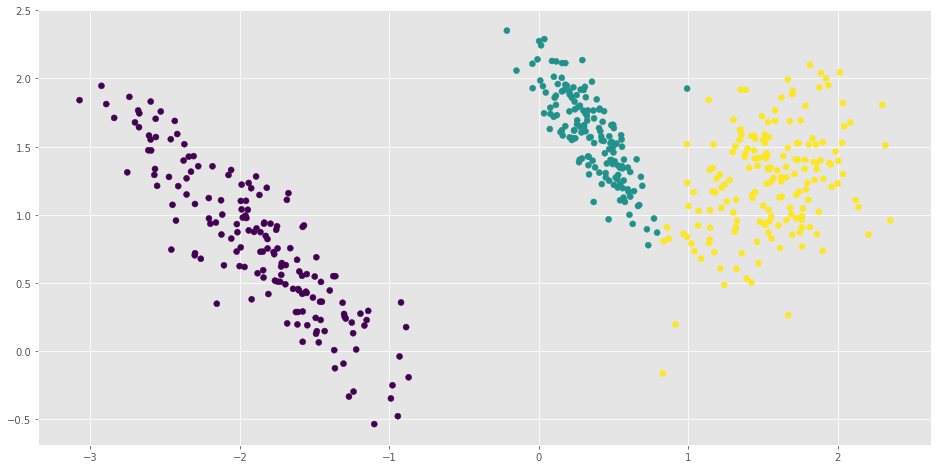

In [6]:
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=3)
km1.fit(x1)
plt.scatter(x1[:, 0], x1[:, 1], c=km1.labels_)
plt.show()

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

#### Description of the algorithm used

First step: initialization

We initialize in a first time the conditional probabilities matrix. Each sample is attributed a class and its conditional probability is 1 for this class and 0 for the others. The class can be attributed either randomly or using the k-means algorithm.

Second step: loop until convergence

We will now proceed with the maximization and expectation steps, looping until convergence. We have chosen a relative movement of the estimators inferior to 0.5% as our stopping criterion.

> Maximization: we maximize the log-likelihood $l(\theta; X, \gamma)$ where $\theta$ are the parameters, $X$ our samples and $\gamma$ the conditional probabilities matrix. The estimators for our parameters $\theta = (\mu_k, \Sigma_k, k \in [ 1, K ])$ are therefore 
>
> $$\hat{\mu_k} = \frac{\sum_{i \in [1, N]} \gamma_{i, k} x_k}{\sum_{i \in [1, N]} \gamma_{i, k}}$$
>
> $$\hat{\Sigma_k} = \frac{\sum_{i\in [1, N]} \gamma_{i, k} (x_i - \overline{x_k}) (x_i - \overline{x_k})^T}{\sum_{i\in [1, N]} \gamma_{i, k}}$$
>
> $$\hat{p_k} = \frac{\sum_i \gamma_{i, k}}{\sum_{i', k'} \gamma_{i', k'}}$$

> Expectation: using the new estimators for the distribution's parameters of each mode, we compute the expectation of the latent unobserved variable $\Delta_i$ ($\Delta_i = 1$ if $x_i$ belongs to mode $i$ and 0 otherwise).
> $$\gamma_{i, k} = E(\Delta_i, \theta, X = x_i) = \text{Pr}(\Delta_i = 1 | \theta, X = X_i)$$
> which means that our update rule will be
> $$\gamma_{i, k} = \frac{\hat{p_k} f_{\hat{\theta_k}}(x_i)}{\sum_{k'} \hat{p_{k'}} f_{\hat{\theta_{k'}}} (x_i)}$$

In [7]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

In [24]:
class my_GMM():
    
    def __init__(self, K, initialization="kmeans", logs=False):
        '''
        Attributes:
        
        K_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array of shape(K, p)
            array containing means
        Sigma_: np.array of shape(K, p, p)
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.K_ = K
        self.initialization_ = initialization.lower()
        self.mu_ = None
        self.Sigma_ = None
        self.P_ = None  # np.array of shape(K)
        self.responsabilities_ = None
        self.labels_ = None
        self._logs = logs
        
    def compute_responsabilities(self, X):
        '''Update the responsabilities matrix of dimension (n, k)'''
        n = X.shape[0]
        p = X.shape[1]
        weighted_probs = np.zeros((n, self.K_))
        for i in range(n):
            for k in range(self.K_):
                weighted_probs[i, k] = self.P_[k] * multivariate_normal.pdf(
                    X[i, :], mean=self.mu_[k, :], cov=self.Sigma_[k, :, :]
                )
        return weighted_probs / np.sum(weighted_probs, axis=1).reshape(-1, 1) 
        
    def update_estimators(self, X):
        '''
        Update the estimators mu and sigma.
        Returns the relative difference (norm 2) between the previous estimators and 
        the new ones (updated in the object).
        '''
        n = X.shape[0]
        p = X.shape[1]
        prev_mu = self.mu_
        if self.mu_ is None:
            self.mu_ = np.zeros((self.K_, p))
        prev_Sigma = self.Sigma_
        if self.Sigma_ is None:
            self.Sigma_ = np.zeros((self.K_, p, p))
        for k in range(self.K_):
            s1 = np.sum(X * self.responsabilities_[:, k].reshape(-1, 1), axis=0)
            s2 = np.sum(self.responsabilities_[:, k].reshape(-1, 1), axis=0)
            self.mu_[k, :] = s1 / s2

            weighted_covariences = np.zeros((n, p, p))
            for i in range(n):
                weighted_covariences[i, :, :] = (X[i, :] - self.mu_[k, :]).reshape((-1, 1)).dot((X[i, :] - self.mu_[k, :]).reshape((1, -1)))
                weighted_covariences[i, :, :] *= self.responsabilities_[i, k]
            self.Sigma_[k, :, :] = np.sum(weighted_covariences, axis=0) / s2

            self.P_ = np.sum(self.responsabilities_, axis=0) / np.sum(self.responsabilities_)
        if prev_mu is None:
            return np.inf
        else:
            diff = np.sqrt(np.sum(np.power(prev_mu - self.mu_, 2)) + np.sum(np.power(prev_Sigma - self.Sigma_, 2)))
            return diff / np.sqrt(np.sum(np.power(prev_mu, 2)) + np.sum(np.power(prev_Sigma, 2)))
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n = X.shape[0]
        p = X.shape[1]
        
        # initialize the parameters
        if self._logs:
            print("Initializing variables.")
        self.init_labels_ = None
        self.responsabilities_ = np.zeros((n, self.K_))
        if self.initialization_ == "kmeans":
            print("Initializing responsabilities using kmeans.")
            kmeans = KMeans(n_clusters=self.K_)
            kmeans.fit(X)
            self.init_labels_ = kmeans.labels_
            for i in range(n):
                self.responsabilities_[i, self.init_labels_[i]] = 1   
        elif self.initialization_ == "random":
            print("Initializing responsabilities using random class attribution.")
            self.init_labels_ = np.random.randint(0, self.K_, size=n)
            for i in range(n):
                self.responsabilities_[i, self.init_labels_[i]] = 1
        else:
            raise NotImplementedError(f"Initialization strategy {self.initialization_} not implemented.")
                             
        
        # Main loop
        movement = np.inf
        iterations = 0
        while movement > 0.0005:
            iterations += 1
            if self._logs:
                print(f"Iteration {iterations}")
                self.labels_ = np.argmax(self.responsabilities_, axis=1)
                plt.scatter(X[:, 0], X[:, 1], c=self.labels_)
                if self.mu_ is not None:
                    plt.scatter(self.mu_[:, 0], self.mu_[:, 1])
                plt.show()
            movement = self.update_estimators(X)
            self.responsabilities_ = self.compute_responsabilities(X)
            
        self.labels_ = np.argmax(self.responsabilities_, axis=1)
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment
        """
        responsabilities = self.compute_responsabilities(X)
        labels = np.argmax(responsabilities, axis=1)
        return labels
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array
        """
        responsabilities = self.compute_responsabilities(X)
        return responsabilities

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

Initializing variables.
Initializing responsabilities using kmeans.
Iteration 1


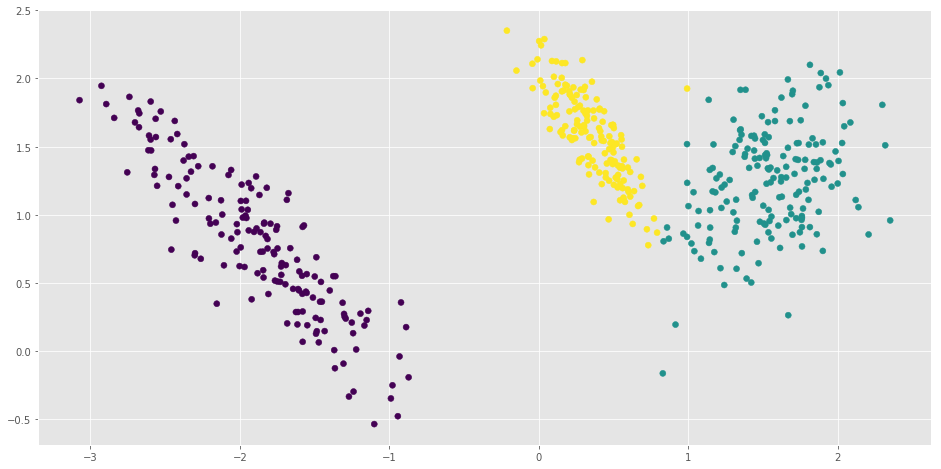

Iteration 2


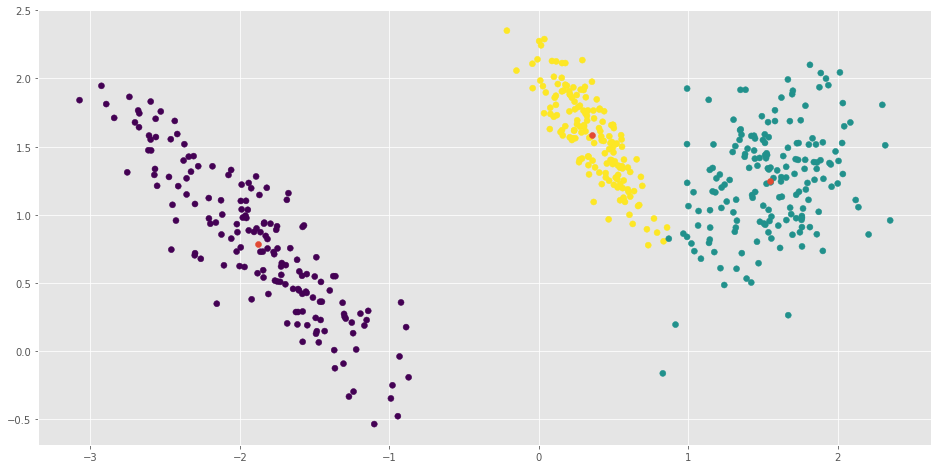

In [25]:
gmm1 = my_GMM(K1, initialization="kmeans", logs=True)
gmm1.fit(x1)

Initializing variables.
Initializing responsabilities using random class attribution.
Iteration 1


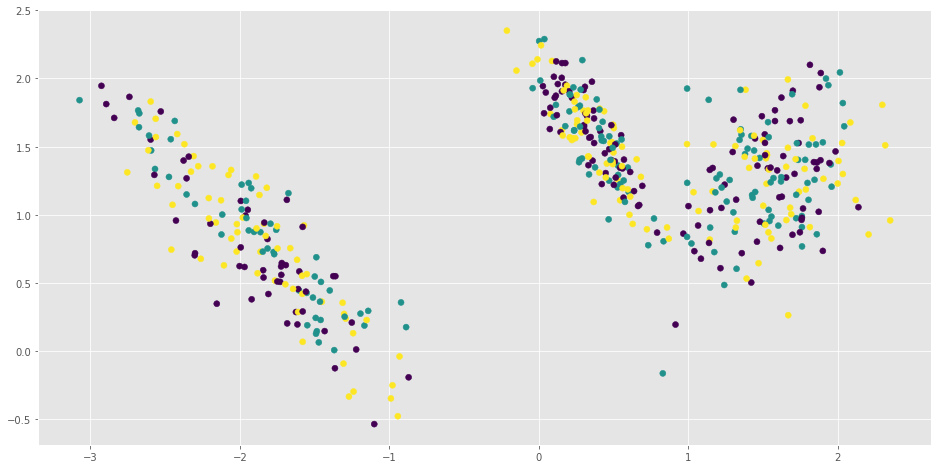

Iteration 2


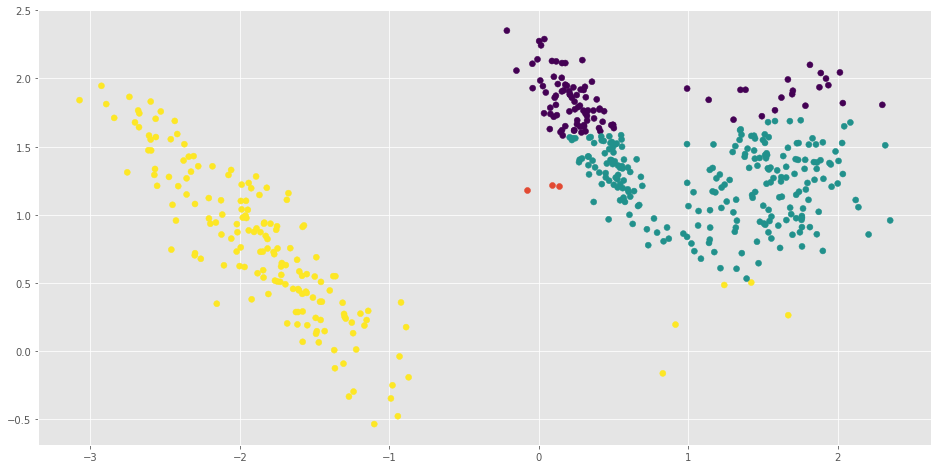

In [26]:
gmm2= my_GMM(K1, initialization="random", logs=True)
gmm2.fit(x1)

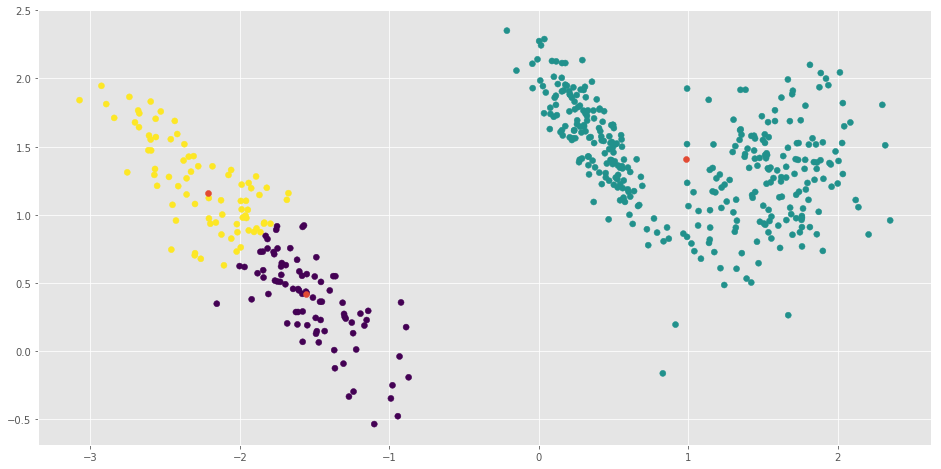

In [27]:
from sklearn.mixture import GaussianMixture
skgmm = GaussianMixture(n_components=3, init_params="kmeans", random_state=seed)
skgmm.fit(x1)
plt.scatter(x1[:, 0], x1[:, 1], c=skgmm.predict(x1))
plt.scatter(skgmm.means_[:, 0], skgmm.means_[:, 1])
plt.show()

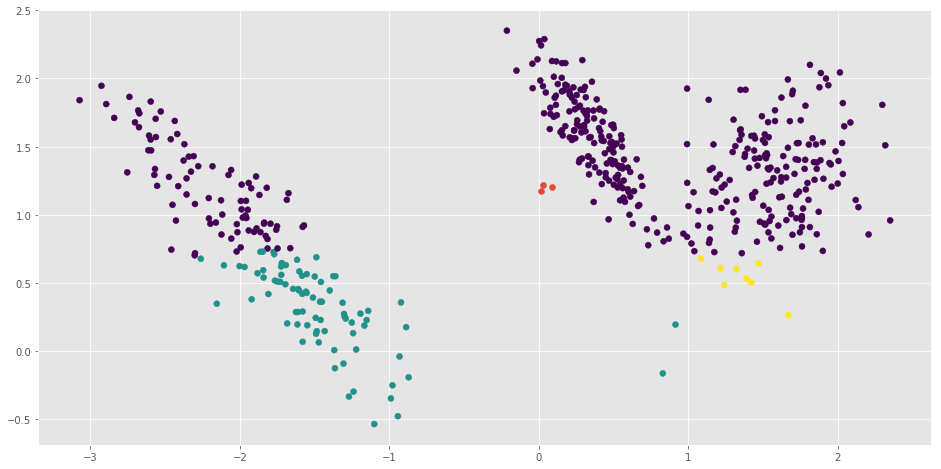

In [28]:
skgmm = GaussianMixture(n_components=3, init_params="random", random_state=seed)
skgmm.fit(x1)
plt.scatter(x1[:, 0], x1[:, 1], c=skgmm.predict(x1))
plt.scatter(skgmm.means_[:, 0], skgmm.means_[:, 1])
plt.show()

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
Implement the seen model selection methods (This part may be updated for the next lab)

In [ ]:
# TODO

## Application

You are going to work with the following data:

shape: (1797, 64)


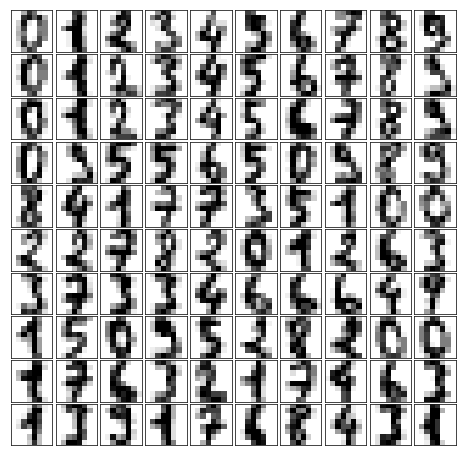

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method and produce new synthetic handwritten numbers. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [ ]:
# TODO